In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import models, transforms, datasets
import torch.optim as optim
import os, pickle, time, copy, glob
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import argparse
import json



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}

trans = ['train_transforms','test_transforms']
path = "/content/gdrive/My Drive/Colab Notebooks/MainDataAug/"
categories = ['train','test']

In [ ]:
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}


In [ ]:
len_train = len(dset['train'])
print('original train dataset size ', len_train) 
len_test = len(dset['test'])
print('original test dataset size ', len_test) 
indices_list = range(len_train)
indices = [*indices_list]

np.random.shuffle(indices)
split = int(np.floor(0.2 * len_train))
train_idx, valid_idx = indices[split:], indices[:split]
print('Upadted train dataset size:', len(train_idx))
print('Created validation dataset size:', len(valid_idx))
test_idx = [i for i in range(len(dset['test']))]
print('the test imagedataest size', len(dset['test']))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

dataset_sizes = {}
dataset_sizes['train'] = train_sampler.__len__()
dataset_sizes['test'] = test_sampler.__len__()
dataset_sizes['val'] = valid_sampler.__len__()
print(dataset_sizes['val'], dataset_sizes['test'], dataset_sizes['train'])


original train dataset size  3847
original test dataset size  3040
Upadted train dataset size: 3078
Created validation dataset size: 769
the test imagedataest size 3040
769 3040 3078


In [ ]:
train_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16,
    drop_last= True, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16, 
    drop_last= True, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(dset['test'], batch_size=16, 
    drop_last= True,sampler=test_sampler,num_workers=0)


In [ ]:
dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
class_names = dset['train'].classes

In [ ]:
images, labels = next(iter(dataloaders['test']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()]))

label: 0, class: covid-n


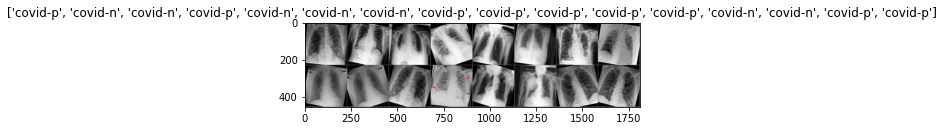

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
inputs,classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)
class_names = dset["train"].classes
imshow(out, title = [class_names[x] for x in classes])


In [ ]:
class ModelVGG16(nn.Module):
    def __init__(self):
        super(ModelVGG16, self).__init__()
        self.model = torchvision.models.vgg16(pretrained=True)
        self.classifier = nn.Sequential(
        nn.Linear(4096,2),
        nn.LogSoftmax(dim=1))
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.classifier[6] = self.classifier

    def forward(self, x):
        return self.model(x)
        
model = ModelVGG16()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []
def fit(self, dataloaders, num_epochs):

        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        if train_on_gpu:
            self.model = self.model.cuda()
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()  
                else:
                    self.model.eval()   
                running_loss = 0.0
                running_corrects = 0
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                if(phase == 'train'):
                  train_losses.append(epoch_loss)   
                  train_acc.append(epoch_acc) 
                if(phase == 'val'):
                  val_losses.append(epoch_loss)   
                  val_acc.append(epoch_acc) 
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model


In [ ]:
num_epochs = 5
model1_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6644 Acc: 0.8538
val Loss: 0.1384 Acc: 0.9701
Epoch 1/4
----------
train Loss: 0.6895 Acc: 0.8964
val Loss: 0.1498 Acc: 0.9610
Epoch 2/4
----------
train Loss: 0.6871 Acc: 0.9084
val Loss: 0.1288 Acc: 0.9701
Epoch 3/4
----------
train Loss: 0.4975 Acc: 0.9396
val Loss: 0.1126 Acc: 0.9766
Epoch 4/4
----------
train Loss: 0.4944 Acc: 0.9357
val Loss: 0.1948 Acc: 0.9662
Training complete in 66m 25s
Best val Acc: 0.976593


In [ ]:
model1_vgg16.eval()
torch.save(model1_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg16_model1_with_aug.pt')

In [ ]:
num_epochs = 10
model2_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8003 Acc: 0.9175
val Loss: 0.1330 Acc: 0.9779
Epoch 1/9
----------
train Loss: 0.7883 Acc: 0.9185
val Loss: 0.3823 Acc: 0.9467
Epoch 2/9
----------
train Loss: 0.8681 Acc: 0.9175
val Loss: 0.3007 Acc: 0.9740
Epoch 3/9
----------
train Loss: 0.7210 Acc: 0.9353
val Loss: 0.1462 Acc: 0.9779
Epoch 4/9
----------
train Loss: 0.7662 Acc: 0.9321
val Loss: 0.0842 Acc: 0.9870
Epoch 5/9
----------
train Loss: 0.6570 Acc: 0.9363
val Loss: 0.1638 Acc: 0.9792
Epoch 6/9
----------
train Loss: 0.5285 Acc: 0.9418
val Loss: 0.0493 Acc: 0.9883
Epoch 7/9
----------
train Loss: 0.6813 Acc: 0.9373
val Loss: 0.1239 Acc: 0.9792
Epoch 8/9
----------
train Loss: 0.5439 Acc: 0.9396
val Loss: 0.1588 Acc: 0.9844
Epoch 9/9
----------
train Loss: 0.6744 Acc: 0.9344
val Loss: 0.0905 Acc: 0.9844
Training complete in 18m 57s
Best val Acc: 0.988296


In [ ]:
model2_vgg16.eval()
torch.save(model2_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg16_model2_with_aug.pt')

In [ ]:
num_epochs = 15
model3_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.0099 Acc: 0.9159
val Loss: 0.1480 Acc: 0.9870
Epoch 1/14
----------
train Loss: 0.8805 Acc: 0.9292
val Loss: 0.1027 Acc: 0.9883
Epoch 2/14
----------
train Loss: 0.8466 Acc: 0.9357
val Loss: 0.1961 Acc: 0.9740
Epoch 3/14
----------
train Loss: 0.7779 Acc: 0.9376
val Loss: 0.1199 Acc: 0.9831
Epoch 4/14
----------
train Loss: 0.6514 Acc: 0.9379
val Loss: 0.1082 Acc: 0.9870
Epoch 5/14
----------
train Loss: 0.7075 Acc: 0.9470
val Loss: 0.1074 Acc: 0.9818
Epoch 6/14
----------
train Loss: 0.7722 Acc: 0.9360
val Loss: 0.0783 Acc: 0.9883
Epoch 7/14
----------
train Loss: 0.7140 Acc: 0.9376
val Loss: 0.1036 Acc: 0.9857
Epoch 8/14
----------
train Loss: 0.5892 Acc: 0.9448
val Loss: 0.1589 Acc: 0.9818
Epoch 9/14
----------
train Loss: 0.7197 Acc: 0.9366
val Loss: 0.1142 Acc: 0.9857
Epoch 10/14
----------
train Loss: 0.6654 Acc: 0.9444
val Loss: 0.1171 Acc: 0.9831
Epoch 11/14
----------
train Loss: 0.6625 Acc: 0.9438
val Loss: 0.1350 Acc: 0.9883
Epoch 12/14
----------
train Loss: 0

In [ ]:
model3_vgg16.eval()
torch.save(model3_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg16_model3_with_aug.pt')

In [ ]:
num_epochs = 20
model4_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6378 Acc: 0.8600
val Loss: 0.2357 Acc: 0.9493
Epoch 1/19
----------
train Loss: 0.8247 Acc: 0.8964
val Loss: 0.0972 Acc: 0.9740
Epoch 2/19
----------
train Loss: 0.7245 Acc: 0.9097
val Loss: 0.2823 Acc: 0.9519
Epoch 3/19
----------
train Loss: 0.4402 Acc: 0.9324
val Loss: 0.1092 Acc: 0.9779
Epoch 4/19
----------
train Loss: 0.4542 Acc: 0.9334
val Loss: 0.1102 Acc: 0.9740
Epoch 5/19
----------
train Loss: 0.4575 Acc: 0.9327
val Loss: 0.1194 Acc: 0.9740
Epoch 6/19
----------
train Loss: 0.4589 Acc: 0.9288
val Loss: 0.1866 Acc: 0.9662
Epoch 7/19
----------
train Loss: 0.4555 Acc: 0.9366
val Loss: 0.1124 Acc: 0.9818
Epoch 8/19
----------
train Loss: 0.4790 Acc: 0.9327
val Loss: 0.1500 Acc: 0.9727
Epoch 9/19
----------
train Loss: 0.4105 Acc: 0.9376
val Loss: 0.0839 Acc: 0.9805
Epoch 10/19
----------
train Loss: 0.4392 Acc: 0.9337
val Loss: 0.1772 Acc: 0.9727
Epoch 11/19
----------
train Loss: 0.3551 Acc: 0.9428
val Loss: 0.1248 Acc: 0.9753
Epoch 12/19
----------
train Loss: 0

In [ ]:
model4_vgg16.eval()
torch.save(model4_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg16_model4_with_aug.pt')

In [ ]:
num_epochs = 25
model5_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7032 Acc: 0.9168
val Loss: 0.2661 Acc: 0.9558
Epoch 1/24
----------
train Loss: 0.7293 Acc: 0.9224
val Loss: 0.1412 Acc: 0.9753
Epoch 2/24
----------
train Loss: 0.7754 Acc: 0.9204
val Loss: 0.2217 Acc: 0.9688
Epoch 3/24
----------
train Loss: 0.8630 Acc: 0.9292
val Loss: 0.1291 Acc: 0.9779
Epoch 4/24
----------
train Loss: 0.7496 Acc: 0.9327
val Loss: 0.1680 Acc: 0.9792
Epoch 5/24
----------
train Loss: 0.6256 Acc: 0.9425
val Loss: 0.2051 Acc: 0.9727
Epoch 6/24
----------
train Loss: 0.5894 Acc: 0.9422
val Loss: 0.1565 Acc: 0.9805
Epoch 7/24
----------
train Loss: 0.6108 Acc: 0.9373
val Loss: 0.1817 Acc: 0.9792
Epoch 8/24
----------
train Loss: 0.6090 Acc: 0.9321
val Loss: 0.1725 Acc: 0.9753
Epoch 9/24
----------
train Loss: 0.5522 Acc: 0.9415
val Loss: 0.1724 Acc: 0.9779
Epoch 10/24
----------
train Loss: 0.6236 Acc: 0.9360
val Loss: 0.1422 Acc: 0.9805
Epoch 11/24
----------
train Loss: 0.5224 Acc: 0.9464
val Loss: 0.1159 Acc: 0.9844
Epoch 12/24
----------
train Loss: 0

In [ ]:
model5_vgg16.eval()
torch.save(model5_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg16_model5_with_aug.pt')